In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from mc2.data_management import EXPERIMENT_LOGS_ROOT,MODEL_DUMP_ROOT
from mc2.models.jiles_atherton import JilesAthertonStatic, JilesAthertonWithGRU, JilesAthertonGRU, JilesAthertonStatic2
from mc2.models.RNN import GRU
from mc2.models.model_interface import JAwGRUwInterface, JAGRUwInterface, load_model, RNNwInterface, JAwInterface
import jax
import equinox as eqx
import json
import pathlib
from typing import Type
from mc2.models.model_interface import ModelInterface
from mc2.runners.model_setup_jax import get_normalizer
import jax.numpy as jnp
from mc2.data_management import EXPERIMENT_LOGS_ROOT, NORMALIZATION_ROOT, load_hdf5_pretest_data

In [4]:
exp_id = "f57e0626"
seed = 1
def load_preds_n_gt(exp_id, seed):
    fp = EXPERIMENT_LOGS_ROOT / f"exp_{exp_id}_seed_{seed}_preds_transformed.parquet"
    fp2 = EXPERIMENT_LOGS_ROOT / f"exp_{exp_id}_seed_{seed}_gt_transformed.parquet"
    fp3 = EXPERIMENT_LOGS_ROOT / f"exp_{exp_id}_seed_{seed}_preds_untransformed.parquet"
    fp4 = EXPERIMENT_LOGS_ROOT / f"exp_{exp_id}_seed_{seed}_gt.parquet"
    preds_transformed_MS = pd.read_parquet(fp).to_numpy()
    preds_untransformed_MS = pd.read_parquet(fp3).to_numpy()
    gt_transformed_MS = pd.read_parquet(fp2).to_numpy()
    gt_MS = pd.read_parquet(fp4).to_numpy()
    return gt_MS, gt_transformed_MS, preds_transformed_MS, preds_untransformed_MS


In [5]:
def plot_worst_predictions3(exp_id, seed, freq_idx, metric="MSE"):
    gt_MS,pred_MS = load_preds_n_gt2(exp_id, seed, freq_idx)
    
    mae_M = np.mean(np.abs(gt_MS - pred_MS), axis=-1)
    mse_M = np.mean((gt_MS - pred_MS)**2, axis=-1)
    rmse_M = np.sqrt(np.mean((gt_MS - pred_MS)**2, axis=-1))/np.sqrt(np.mean(gt_MS**2, axis=-1))
    if metric=="RMSE":
        sorted_idx = np.argsort(rmse_M)[::-1]
    elif metric=="MAE":
        sorted_idx = np.argsort(mae_M)[::-1]
    else:   
        sorted_idx = np.argsort(mse_M)[::-1]
    worst_idx=sorted_idx[:5]
    
    print(f"MAE {mae_M.mean():.1f} A/m | MSE {mse_M.mean():.1f} (A/m)² | RMSE {rmse_M.mean():.3f}")

    fig, axes = plt.subplots(5, 1 , sharex=True, sharey="col", figsize=(10, 15))
    axes[0].set_title(f"Worst {metric}")
    for i,idx in enumerate(worst_idx):
        ax = axes[i]
        ax.plot(gt_MS[idx], label='gt')
        ax.plot(pred_MS[idx], label='pred', ls='dashed')
        ax.annotate(f"MAE {mae_M[idx]:.1f} A/m | "
                    f"MSE {mse_M[idx]:.1f} (A/m)² | RMSE {rmse_M[idx]:.3f}", 
                    (0.3, 0.1), xycoords=ax.transAxes)
            
    axes.flatten()[0].legend()
    for ax in axes.flatten():
        ax.grid(alpha=0.3)
    for ax in axes:
        ax.set_ylabel("H in A/m")
    for ax in [axes[-1]]:
        ax.set_xlabel("Sequence step")

    fig.tight_layout()

In [6]:

def plot_first_predictions(exp_key, show_normalized_pred=False):
    gt_MS, gt_transformed_MS, preds_transformed_MS, preds_untransformed_MS = load_preds_n_gt(**experiments_d[exp_key])
    fig, axes = plt.subplots(5, 1 + int(show_normalized_pred), sharex=True, sharey="col", figsize=(10, 15))
    mae_M = np.mean(np.abs(gt_MS - preds_untransformed_MS), axis=-1)
    mse_M = np.mean((gt_MS - preds_untransformed_MS)**2, axis=-1)
    print(f"MAE {mae_M.mean():.1f} A/m | MSE {mse_M.mean():.1f} (A/m)²")
    for tst_idx in range(axes.shape[0]):
        if show_normalized_pred:
            ax = axes[tst_idx, 0]
        else:
            ax = axes[tst_idx]
        ax.plot(gt_MS[tst_idx], label='gt')
        ax.plot(preds_untransformed_MS[tst_idx], label='pred', ls='dashed')
        ax.annotate(f"MAE {mae_M[tst_idx]:.1f} A/m | "
                    f"MSE {mse_M[tst_idx]:.1f} (A/m)²",
                    (0.3, 0.1), xycoords=ax.transAxes)
        if show_normalized_pred:
            axes[tst_idx, 1].plot(gt_transformed_MS[tst_idx])
            axes[tst_idx, 1].plot(preds_transformed_MS[tst_idx], ls='dashed')
            
    axes.flatten()[0].legend()
    for ax in axes.flatten():
        ax.grid(alpha=0.3)
    for ax in axes[:, 0] if show_normalized_pred else axes:
        ax.set_ylabel("H in A/m")
    if show_normalized_pred:
        for ax in axes[:, 1]:
            ax.set_ylabel("H normalized")
    for ax in axes[-1, :] if show_normalized_pred else [axes[-1]]:
        ax.set_xlabel("Sequence step")
    fig.tight_layout()


In [7]:
def load_preds_n_gt2(exp_id, seed, freq_idx):
    gt = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{freq_idx}_gt.parquet"
    pred = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{freq_idx}_preds.parquet"
    gt_MS = pd.read_parquet(gt).to_numpy()
    pred_MS = pd.read_parquet(pred).to_numpy()
    return gt_MS, pred_MS

In [8]:
def freq_test_mse_mae(exp_id, seed):
    mses=[]
    maes=[]
    for idx in range(7):
        gt = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{idx}_gt.parquet"
        pred = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{idx}_preds.parquet"
        gt_MS = pd.read_parquet(gt).to_numpy()
        pred_MS = pd.read_parquet(pred).to_numpy()
        mse_M = np.mean((gt_MS - pred_MS)**2)
        mae_M = np.mean(np.abs(gt_MS - pred_MS))
        mses.append(mse_M)
        maes.append(mae_M)
    return mses,maes

In [9]:
def plot_first_predictions2(exp_id, seed, freq_idx):
    gt_MS,pred_MS = load_preds_n_gt2(exp_id, seed, freq_idx)
    fig, axes = plt.subplots(5, 1 , sharex=True, sharey="col", figsize=(10, 15))
    mae_M = np.mean(np.abs(gt_MS - pred_MS), axis=-1)
    mse_M = np.mean((gt_MS - pred_MS)**2, axis=-1)
    print(f"MAE {mae_M.mean():.1f} A/m | MSE {mse_M.mean():.1f} (A/m)²")
    for tst_idx in range(axes.shape[0]):
        ax = axes[tst_idx]
        ax.plot(gt_MS[tst_idx], label='gt')
        ax.plot(pred_MS[tst_idx], label='pred', ls='dashed')
        ax.annotate(f"MAE {mae_M[tst_idx]:.1f} A/m | "
                    f"MSE {mse_M[tst_idx]:.1f} (A/m)²",
                    (0.3, 0.1), xycoords=ax.transAxes)
            
    axes.flatten()[0].legend()
    for ax in axes.flatten():
        ax.grid(alpha=0.3)
    for ax in axes:
        ax.set_ylabel("H in A/m")
    for ax in [axes[-1]]:
        ax.set_xlabel("Sequence step")
    fig.tight_layout()

In [10]:
def plot_worst_predictions2(exp_id, seed, freq_idx):
    gt_MS,pred_MS = load_preds_n_gt2(exp_id, seed, freq_idx)
    
    mae_M = np.mean(np.abs(gt_MS - pred_MS), axis=-1)
    mse_M = np.mean((gt_MS - pred_MS)**2, axis=-1)
    sorted_idx = np.argsort(mse_M)[::-1]
    worst_mse=sorted_idx[:5]
    sorted_idx = np.argsort(mae_M)[::-1]
    worst_mae=sorted_idx[:5]
    print(f"MAE {mae_M.mean():.1f} A/m | MSE {mse_M.mean():.1f} (A/m)²")

    for metric in ["MSE","MAE"]:
        worst_idx = worst_mse if metric=="MSE" else worst_mae
        fig, axes = plt.subplots(5, 1 , sharex=True, sharey="col", figsize=(10, 15))
        axes[0].set_title(f"Worst {metric}")
        for i,idx in enumerate(worst_idx):
            ax = axes[i]
            ax.plot(gt_MS[idx], label='gt')
            ax.plot(pred_MS[idx], label='pred', ls='dashed')
            ax.annotate(f"MAE {mae_M[idx]:.1f} A/m | "
                        f"MSE {mse_M[idx]:.1f} (A/m)²",
                        (0.3, 0.1), xycoords=ax.transAxes)
                
        axes.flatten()[0].legend()
        for ax in axes.flatten():
            ax.grid(alpha=0.3)
        for ax in axes:
            ax.set_ylabel("H in A/m")
        for ax in [axes[-1]]:
            ax.set_xlabel("Sequence step")

        fig.tight_layout()

In [11]:
def freq_test_mse_rmse(exp_id, seed):
    mses=[]
    rmse=[]
    for idx in range(7):
        gt = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{idx}_gt.parquet"
        pred = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{idx}_preds.parquet"
        gt_MS = pd.read_parquet(gt).to_numpy()
        pred_MS = pd.read_parquet(pred).to_numpy()
        mse_per_sequence_M = np.mean((pred_MS - gt_MS) ** 2, axis=1)
        mse_M = np.mean(mse_per_sequence_M)
        sre_per_sequence = np.sqrt(mse_per_sequence_M) / np.sqrt(np.mean(gt_MS**2, axis=1))
        rmse_M = np.mean(sre_per_sequence)
        mses.append(mse_M)
        rmse.append(rmse_M)
    return mses,rmse

In [34]:
#exp_id = "3C90_8c804f77"#"3C90_78f120d2"
#exp_id ="3C90_7632996d-4c4c-40"#(RMS-GRU8)#"3C90_4d5b2cc1-4e08-46"#"3C90_5cf07234-fbc2-44" #(RMS-JA+GRu 10epoche) # ##(MSE-GRU8)#
#exp_id = "3C90_b8d1fe17-2f6f-40" #(JA-100)
#exp_id = "3C90_0a78ff01-c96b-4d" #(JA-WITH-GRU8-100)
exp_id = "3C90_a309167c-3e73-40" #(GRU8-150)
#exp_id = "3C90_1c1af93c-e010-4a" #(JAGRU-100)
#exp_id = "3C90_e7266ae8-99a8-42" #(JA2-25)
#exp_id = "3C90_c78a3d43-ce9e-46" #(JAGRUlin-100)
#exp_id = "3C90_a4e69149-1e9f-4d" #(JA2-100)
seed = 0



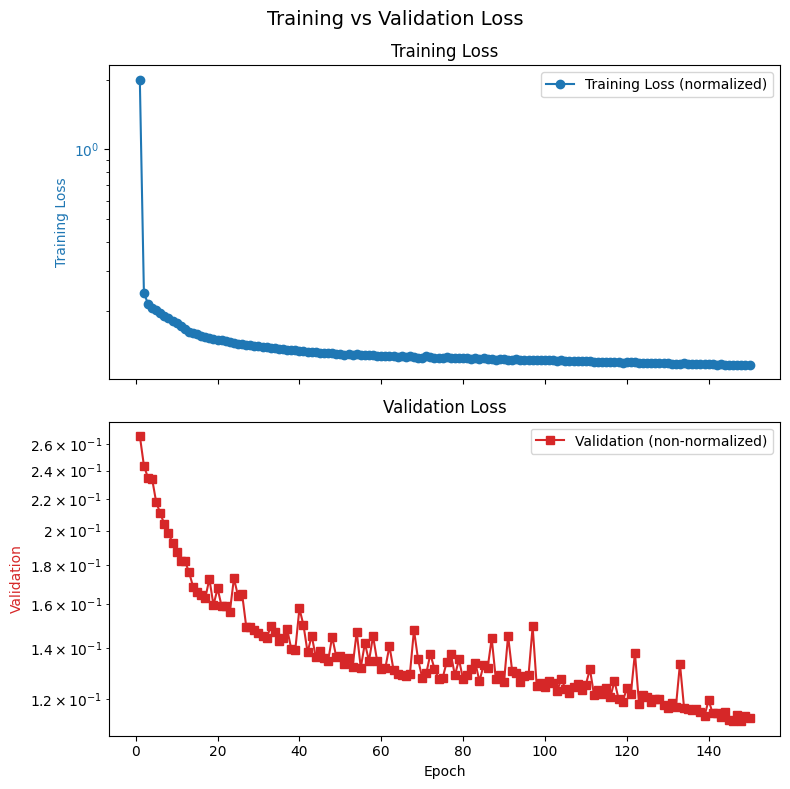

In [35]:
loss_trend = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_loss_trends.parquet"
loss_train_val = pd.read_parquet(loss_trend).to_numpy()

epochs = np.arange(1, len(loss_train_val) + 1)
train_loss = loss_train_val[:, 0]
val_loss = loss_train_val[:, 1]

# Figure mit zwei Subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Training Loss Plot
axes[0].plot(epochs, train_loss, color="tab:blue", marker="o", label="Training Loss (normalized)")
axes[0].set_ylabel("Training Loss", color="tab:blue")
axes[0].tick_params(axis="y", labelcolor="tab:blue")
axes[0].legend(loc="upper right")
axes[0].set_title("Training Loss")
axes[0].set_yscale("log")

# Validation Loss Plot
axes[1].plot(epochs, val_loss, color="tab:red", marker="s", label="Validation (non-normalized)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation", color="tab:red")
axes[1].tick_params(axis="y", labelcolor="tab:red")
axes[1].legend(loc="upper right")
axes[1].set_title("Validation Loss")
axes[1].set_yscale("log")
# Layout und Anzeige
fig.suptitle("Training vs Validation Loss", fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
from mc2.features.features_jax import compute_fe_single
def featurize(norm_B_past, norm_H_past, norm_B_future, temperature):
        past_length = norm_B_past.shape[0]
        future_length = norm_B_future.shape[0]

        featurized_B = compute_fe_single(jnp.hstack([norm_B_past, norm_B_future]), n_s=10)

        return featurized_B[past_length:]

normalizer, data_tuple = get_normalizer(
    "3C90",
    featurize,
    1,
    True,
)

Loading data for 3C90: 100%|██████████| 21/21 [00:11<00:00,  1.77it/s]
INFO:2025-10-01 17:12:45,255:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-10-01 17:12:45 | INFO : Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-10-01 17:12:45,259:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-10-01 17:12:45 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [20]:
from functools import partial
JilesAthertonGRU_part = partial(JilesAthertonGRU, normalizer=normalizer)

loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id[5:]}.eqx",JilesAthertonWithGRU) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model = JAwGRUwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

NameError: name 'normalizer' is not defined

In [87]:
import json 
training_data_path = EXPERIMENT_LOGS_ROOT /"jax_experiments"/ f"{exp_id [5:]}.json"
with open(training_data_path, "r") as f:
    training_and_test_data = json.load(f)

In [22]:
mses,rmses = freq_test_mse_rmse(exp_id, seed)
print("Total:", f"RMSE {np.mean(rmses):.3f} A/m | MSE {np.mean(mses).mean():.1f} (A/m)²", "\n")
for i,(val_mse,val_rmse) in enumerate(zip(mses,rmses)):
    print(f"Freq_idx {i}: ",f"RMSE {(val_rmse):.3f} A/m | MSE {(val_mse).mean():.1f} (A/m)²")

Total: RMSE 0.214 A/m | MSE 475.4 (A/m)² 

Freq_idx 0:  RMSE 0.436 A/m | MSE 2886.9 (A/m)²
Freq_idx 1:  RMSE 0.201 A/m | MSE 205.4 (A/m)²
Freq_idx 2:  RMSE 0.150 A/m | MSE 79.0 (A/m)²
Freq_idx 3:  RMSE 0.157 A/m | MSE 142.8 (A/m)²
Freq_idx 4:  RMSE 0.170 A/m | MSE 2.3 (A/m)²
Freq_idx 5:  RMSE 0.176 A/m | MSE 4.0 (A/m)²
Freq_idx 6:  RMSE 0.207 A/m | MSE 7.2 (A/m)²


MAE 2.5 A/m | MSE 73.8 (A/m)² | RMSE 0.149


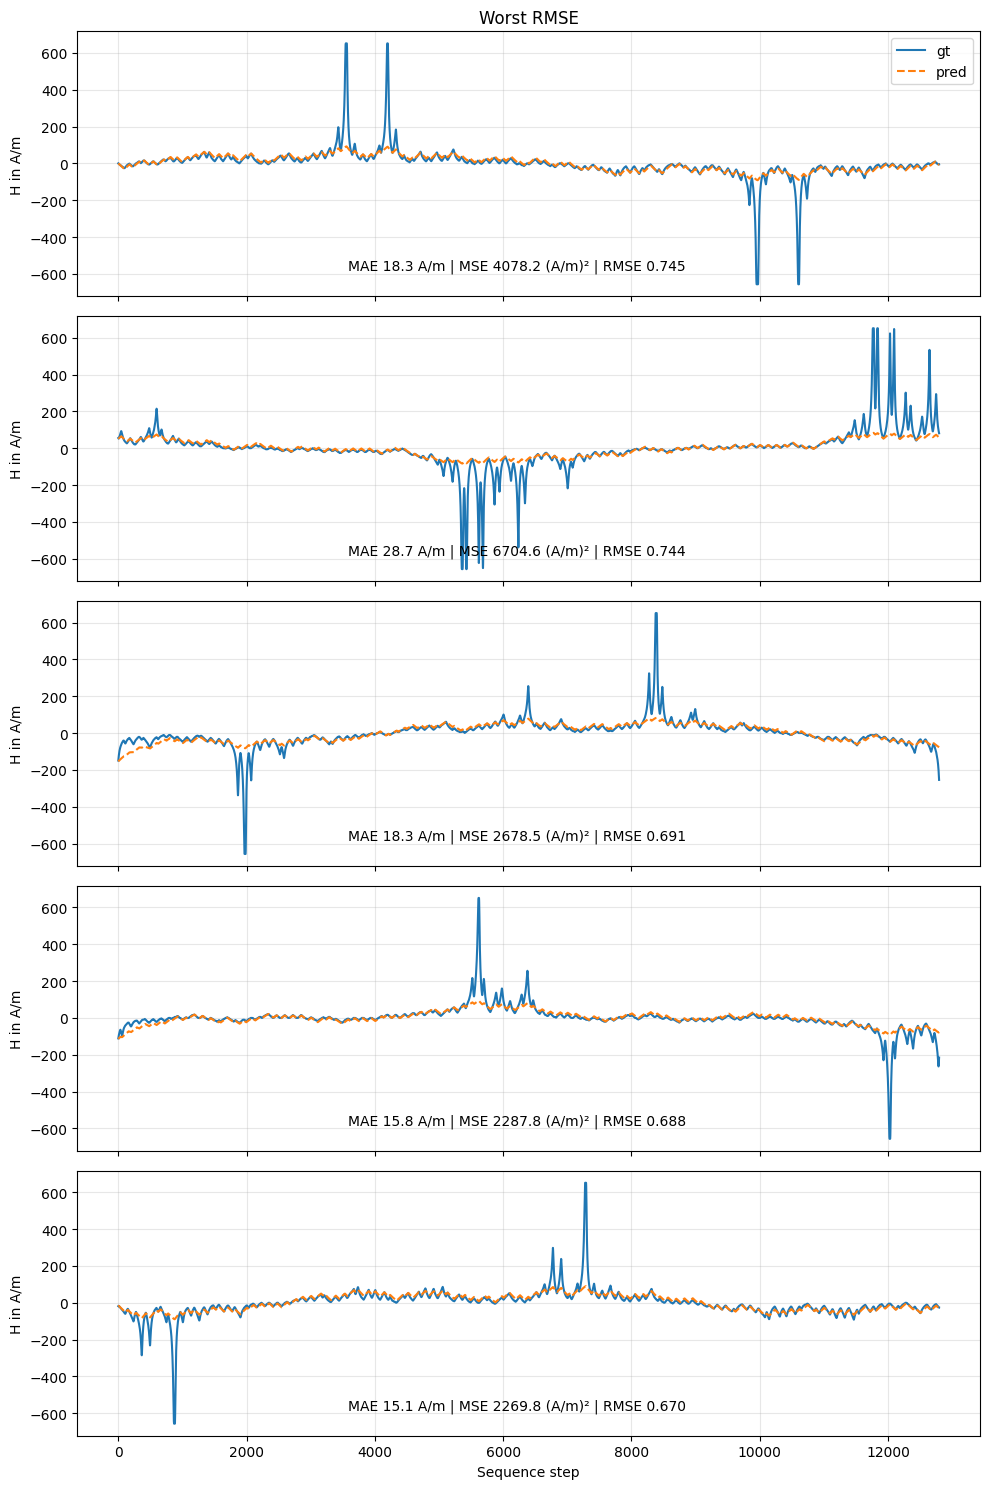

In [60]:
plot_worst_predictions3(exp_id, seed,2, metric="RMSE")

## Pretest

In [14]:
from mc2.features.features_jax import compute_fe_single
def featurize(norm_B_past, norm_H_past, norm_B_future, temperature):
        past_length = norm_B_past.shape[0]
        future_length = norm_B_future.shape[0]

        featurized_B = compute_fe_single(jnp.hstack([norm_B_past, norm_B_future]), n_s=10)

        return featurized_B[past_length:]

normalizer, data_tuple = get_normalizer(
    "3C90",
    featurize,
    1,
    True,
)

Loading data for 3C90: 100%|██████████| 21/21 [00:11<00:00,  1.77it/s]
INFO:2025-10-02 10:42:29,255:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-10-02 10:42:29 | INFO : Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-10-02 10:42:29,258:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-10-02 10:42:29 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [12]:
seed = 0
#exp_id = "3C90_8c804f77"#"3C90_78f120d2"
#exp_id ="3C90_7632996d-4c4c-40"#(RMS-GRU8)#"3C90_4d5b2cc1-4e08-46"#"3C90_5cf07234-fbc2-44" #(RMS-JA+GRu 10epoche) # ##(MSE-GRU8)#
exp_id_ja = "3C90_b8d1fe17-2f6f-40" #(JA-100)
#exp_id = "3C90_0a78ff01-c96b-4d" #(JA-WITH-GRU8-100)
exp_id_gru = "3C90_a309167c-3e73-40" #(GRU8-150)
#exp_id = "3C90_1c1af93c-e010-4a" #(JAGRU-100)
#exp_id = "3C90_e7266ae8-99a8-42" #(JA2-25)
exp_id_jagru = "3C90_c78a3d43-ce9e-46" #(JAGRUlin-100)
exp_id_ja2 = "3C90_a4e69149-1e9f-4d" #(JA2-100)

In [15]:
from functools import partial

JilesAthertonGRU_part = partial(JilesAthertonGRU, normalizer=normalizer)
loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_jagru[5:]}.eqx",JilesAthertonGRU_part) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_ja_gru = JAGRUwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_gru[5:]}.eqx",GRU) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_gru = RNNwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_ja[5:]}.eqx",JilesAthertonStatic) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_ja = JAwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface


loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_ja2[5:]}.eqx",JilesAthertonStatic2) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_ja2 = JAwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

/home/olivers/mc_2/magnet-challenge-2/mc2/models/model_interface.py:202: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = model_class(key=jax.random.PRNGKey(0), **hyperparams)


In [16]:
from IPython.display import display, HTML
def create_multilevel_df(nested_dict):
    """Convert 3-level nested dict to DataFrame with outer keys as index and 2-level columns"""
    dfs_by_model = []
    for model_name, model_metrics in nested_dict.items():
        # Create tuples for MultiIndex columns (scenario, metric)
        tuples = [(scenario, metric) for scenario in model_metrics.keys() for metric in model_metrics[scenario].keys()]
        values = [model_metrics[scenario][metric] for scenario in model_metrics.keys() for metric in model_metrics[scenario].keys()]
        
        # Create DataFrame for this model
        df_model = pd.DataFrame([values], columns=pd.MultiIndex.from_tuples(tuples), index=[model_name])
        dfs_by_model.append(df_model)
    
    # Concatenate and set column names
    df = pd.concat(dfs_by_model, axis=0)
    #df.columns.names = ['Scenario', 'Metric']
    return df

In [17]:
mat = "3C90"
B, T, H_init, H_true, loss, loss_short, msks_scenarios_N_tup = load_hdf5_pretest_data(mat)
B.shape, T.shape, H_init.shape, H_true.shape

Scenario counts: [2100 2100 2100]


((6300, 1000), (6300, 1), (6300, 1000), (6300, 1000))

In [31]:
H_init

array([[  4.15323925,   4.21356726,   4.26732731, ...,          nan,
                 nan,          nan],
       [ 25.8999958 ,  26.04748535,  26.18721771, ...,          nan,
                 nan,          nan],
       [-32.68727875, -32.83828354, -32.98651886, ...,          nan,
                 nan,          nan],
       ...,
       [-11.44004726, -10.35359478,  -9.11106396, ...,          nan,
                 nan,          nan],
       [-15.65936756, -15.99971294, -15.9355011 , ...,          nan,
                 nan,          nan],
       [ -0.33111066,  -1.1119777 ,  -2.05299616, ...,          nan,
                 nan,          nan]], shape=(6300, 1000))

In [24]:
msks_scenarios_N_tup

(array([False, False, False, ...,  True,  True,  True], shape=(6300,)),
 array([False, False, False, ..., False, False, False], shape=(6300,)),
 array([ True,  True,  True, ..., False, False, False], shape=(6300,)))

In [29]:
scenario_labels = ["10% unknown", "50% unknown", "90% unknown"]

def evaluate_pretest_scenarios_custom(
    model_all, B, T, H_init, H_true, loss, msks_scenarios_N_tup, show_plots: bool = False
):
    """
    Evaluates the given model on pretest scenarios with different amounts of unknown samples.
    Works with batched NumPy inputs (model_all takes arrays of shape (batch, time)).
    """

    metrics_d = {}

    for scenario_i, msk_N in enumerate(msks_scenarios_N_tup):
        print(f"  Scenario {scenario_i} - {scenario_labels[scenario_i]}: ")

        B_scenario = B[msk_N]
        T_scenario = T[msk_N]
        H_init_scenario = H_init[msk_N]
        H_true_scenario = H_true[msk_N]

        warm_up_len = np.sum(~np.isnan(H_init_scenario[0]))
        print(warm_up_len/B_scenario.shape[1])
        print(f"    -> warm_up_len = {warm_up_len}")


        B_past = B_scenario[:, :warm_up_len]
        H_past = H_init_scenario[:, :warm_up_len]
        B_future = B_scenario[:, warm_up_len:]
        T_batch = T_scenario.reshape(-1) 

        preds = model_all(
            B_past=B_past,
            H_past=H_past,
            B_future=B_future,
            T=T_batch,
        ) 

        H_gt = H_true_scenario[:, warm_up_len:]

        # ---- metrics ----
        wce_per_sequence = np.max(np.abs(preds - H_gt), axis=1)
        mse_per_sequence = np.mean((preds - H_gt) ** 2, axis=1)

        mse = np.mean(mse_per_sequence)
        wce = np.max(np.abs(preds - H_gt))
        sre_per_sequence = np.sqrt(mse_per_sequence) / np.sqrt(np.mean(H_gt**2, axis=1))
        sre_avg = np.mean(sre_per_sequence)
        sre_95th = np.percentile(sre_per_sequence, 95)

        dbdt_full = np.gradient(B_scenario, axis=1)
        dbdt = dbdt_full[:, warm_up_len:]
        nere_per_sequence = np.abs((((dbdt * preds) - (dbdt * H_gt)).sum(axis=1)) / np.abs(loss[msk_N])) #added abs
        nere_avg = np.mean(nere_per_sequence)
        nere_95th = np.percentile(nere_per_sequence, 95)

        print(f"\tMSE : {mse:>7.2f} (A/m)²")
        print(f"\tWCE : {wce:>7.2f} A/m")

        metrics_d[scenario_labels[scenario_i]] = {
            "mse": np.round(mse, 3).item(),
            "wce": np.round(wce, 3).item(),
            "sre_avg": np.round(sre_avg, 3).item(),
            "sre_95th": np.round(sre_95th, 3).item(),
            "nere_avg": np.round(nere_avg, 3).item(),
            "nere_95th": np.round(nere_95th, 3).item(),
        }

        # optional plots
        if show_plots:
            n_plots = min(5, preds.shape[0])
            idx_argmax = np.argpartition(wce_per_sequence, -n_plots)[-n_plots:]

            fig, axes = plt.subplots(n_plots, 1, sharex=True, figsize=(10, 2.5 * n_plots))
            if n_plots == 1:
                axes = [axes]
            for j, idx in enumerate(idx_argmax):
                ax = axes[j]
                ax.plot(H_gt[idx], label="gt")
                ax.plot(preds[idx], label="pred", ls="dashed")
                ax.annotate(
                    f"MSE {mse_per_sequence[idx]:.1f} (A/m)² | WCE {wce_per_sequence[idx]:.1f} A/m",
                    (0.3, 0.1), xycoords=ax.transAxes
                )
                ax.grid(alpha=0.3)
                ax.set_ylabel("H in A/m")
            axes[0].set_title(f"Worst-case predictions - {scenario_labels[scenario_i]}")
            axes[-1].set_xlabel("Sequence step")
            axes[0].legend()
            fig.tight_layout()

    return metrics_d


In [30]:
metrics_model_ja = evaluate_pretest_scenarios_custom(wrappend_model_ja,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_ja2 = evaluate_pretest_scenarios_custom(wrappend_model_ja2,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_ja_gru = evaluate_pretest_scenarios_custom(wrappend_model_ja_gru,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_gru = evaluate_pretest_scenarios_custom(wrappend_model_gru,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)

  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :   49.60 (A/m)²
	WCE :  357.75 A/m
  Scenario 1 - 50% unknown: 
0.5
    -> warm_up_len = 500
	MSE :  443.74 (A/m)²
	WCE :  571.26 A/m
  Scenario 2 - 90% unknown: 
0.1
    -> warm_up_len = 100
	MSE :  450.58 (A/m)²
	WCE :  576.35 A/m
  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :   47.07 (A/m)²
	WCE :  357.41 A/m
  Scenario 1 - 50% unknown: 
0.5
    -> warm_up_len = 500
	MSE :  430.52 (A/m)²
	WCE :  569.28 A/m
  Scenario 2 - 90% unknown: 
0.1
    -> warm_up_len = 100
	MSE :  437.09 (A/m)²
	WCE :  575.16 A/m
  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :   63.83 (A/m)²
	WCE :  383.38 A/m
  Scenario 1 - 50% unknown: 
0.5
    -> warm_up_len = 500
	MSE :  213.56 (A/m)²
	WCE :  576.60 A/m
  Scenario 2 - 90% unknown: 
0.1
    -> warm_up_len = 100
	MSE :  214.98 (A/m)²
	WCE :  569.85 A/m
  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :   25.81 (A/m)²
	WCE :  262.47 A/m
  Scenario

In [22]:
hosts_d = {"3C90": {scenario_labels[0]: {"mse": None, "wce": None, "sre_avg": 0.1305, "sre_95th": 0.347, "nere_avg": 0.007623, "nere_95th": 0.01928}, # 90 % known
           scenario_labels[1]: {"mse": None, "wce": None, "sre_avg": 0.1602, "sre_95th": 0.3443, "nere_avg": 0.0341, "nere_95th": 0.05603}, # 50 % known
           scenario_labels[2]: {"mse": None, "wce": None, "sre_avg": 0.1704, "sre_95th": 0.3476, "nere_avg": 0.0618, "nere_95th": 0.07476}}, # 10 % known
           "N87": {scenario_labels[0]: {"mse": None, "wce": None, "sre_avg": 0.1962, "sre_95th": 0.521, "nere_avg": 0.007805, "nere_95th": 0.0157}, # 90 % known
           scenario_labels[1]: {"mse": None, "wce": None, "sre_avg": 0.2767, "sre_95th": 0.8498, "nere_avg": 0.02577, "nere_95th": 0.05509}, # 50 % known
           scenario_labels[2]: {"mse": None, "wce": None, "sre_avg": 0.3028, "sre_95th": 0.9999, "nere_avg": 0.04828, "nere_95th": 0.0681} # 10 % known
           }}
all_models_d = {"hosts": hosts_d[mat], "GRU": metrics_model_gru, "JA": metrics_model_ja,"JAGRUlin": metrics_model_ja_gru ,"JA2": metrics_model_ja2}

In [23]:
# 3C90
df_models_3C90 = create_multilevel_df(all_models_d)
display(HTML(df_models_3C90.T.to_html(float_format="%.3f", bold_rows=False)))

/tmp/ipykernel_3760869/586201257.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs_by_model, axis=0)
